#0. Weather

* [Weather dataset Kaggle](https://www.kaggle.com/datasets/vijaygiitk/multiclass-weather-dataset)

## 라이브러리 로드

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import tqdm as tqdm
import glob

In [ ]:
import cv2

## 이미지 로드

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
root_dir = "/gdrive/My Drive/Colab Notebooks/data/weather"
image_label = os.listdir(root_dir)
image_label.remove("test.csv")
image_label

['cloudy', 'sunrise', 'rainy', 'alien_test', 'foggy', 'shine']

#1. 데이터셋 만들기

In [ ]:
def img_read_resize(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (120, 120))
    return img

In [ ]:
def img_folder_read(img_label):
    """ 
    목적 : 폴더별 이미지 읽어오는 함수
    특정 폴더에 있는 이미지를 
    array 형태로 읽어와서 리스트에 담아주는 함수
    형식에 맞지 않는 이미지는 제외하고 가져오도록 try, except 를 사용
    """
    img_files = []
    labels = []
    wfiles = glob.glob(f"{root_dir}/{img_label}/*")
    wfiles = sorted(wfiles)
    for w_img in wfiles:
        try:
            img_files.append(img_read_resize(w_img))
            labels.append(img_label)
        except:
            continue
    return img_files, labels

In [ ]:
image_label

['cloudy', 'sunrise', 'rainy', 'alien_test', 'foggy', 'shine']

In [ ]:
x_train_img = []
x_test_img = []
y_train_img = []
y_test_img = []

for img_label in tqdm.tqdm(image_label):
    
    x_temp, y_temp = img_folder_read(img_label)

    if img_label == "alien_test":
        x_test_img.extend(x_temp)
        y_test_img.extend(y_temp)
    else:
        x_train_img.extend(x_temp)
        y_train_img.extend(y_temp)

100%|██████████| 6/6 [00:15<00:00,  2.65s/it]


In [ ]:
x_train_arr = np.array(x_train_img)
y_train_arr = np.array(y_train_img)
x_test_arr = np.array(x_test_img)
y_test_arr = np.array(y_test_img)

In [ ]:
from sklearn.model_selection import train_test_split

x_train_raw, x_valid_raw, y_train_raw, y_valid_raw = train_test_split(
    x_train_arr, y_train_arr, test_size=0.2, stratify=y_train_arr, random_state=42)

x_train_raw.shape, x_valid_raw.shape, y_train_raw.shape, y_valid_raw.shape

((1198, 120, 120, 3), (300, 120, 120, 3), (1198,), (300,))

In [ ]:
# 정규화
x_train = x_train_raw / 255
x_valid = x_valid_raw / 255
x_test = x_test_arr / 255

x_train[0].max(), x_valid[0].max(), x_test[0].max()

(1.0, 1.0, 1.0)

## LabelBinarizer
* [sklearn.preprocessing.LabelBinarizer — scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html)

In [ ]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(y_train_raw)
print(lb.classes_)

y_train = lb.transform(y_train_raw)
y_valid = lb.transform(y_valid_raw)

['cloudy' 'foggy' 'rainy' 'shine' 'sunrise']


#2. CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [ ]:
n_class = len(lb.classes_)
n_class

5

In [ ]:
model = Sequential()

# 입력층
model.add(Conv2D(filters=16, kernel_size=(3,3), 
                 activation='relu', input_shape=x_train[0].shape))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

# Flatten
model.add(Flatten())
model.add(Dense(units=64, activation="relu"))
model.add(Dropout(0.2))

# 출력층
model.add(Dense(n_class, activation='softmax'))

In [ ]:
# summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 59, 59, 16)        0         
                                                                 
 flatten (Flatten)           (None, 55696)             0         
                                                                 
 dense (Dense)               (None, 64)                3564608   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

## compile

In [ ]:
model.compile(optimizer="adam", 
              loss="categorical_crossentropy",
              metrics=["accuracy"]
             )

## fit

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, verbose=1,)

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), 
                    epochs=20, callbacks=[earlystop])

Epoch 1/20
38/38 [==============================] - 11s 21ms/step - loss: 1.4774 - accuracy: 0.5509 - val_loss: 0.8109 - val_accuracy: 0.7100
Epoch 2/20
38/38 [==============================] - 0s 10ms/step - loss: 0.7753 - accuracy: 0.7187 - val_loss: 0.6999 - val_accuracy: 0.7533
Epoch 3/20
38/38 [==============================] - 0s 11ms/step - loss: 0.6389 - accuracy: 0.7538 - val_loss: 0.6329 - val_accuracy: 0.7967
Epoch 4/20
38/38 [==============================] - 0s 11ms/step - loss: 0.5227 - accuracy: 0.8088 - val_loss: 0.5369 - val_accuracy: 0.8033
Epoch 5/20
38/38 [==============================] - 0s 11ms/step - loss: 0.4372 - accuracy: 0.8364 - val_loss: 0.5290 - val_accuracy: 0.8067
Epoch 6/20
38/38 [==============================] - 0s 10ms/step - loss: 0.4101 - accuracy: 0.8447 - val_loss: 0.5525 - val_accuracy: 0.8067
Epoch 7/20
38/38 [==============================] - 0s 10ms/step - loss: 0.3358 - accuracy: 0.8840 - val_loss: 0.6426 - val_accuracy: 0.7967
Epoch 8/20
3

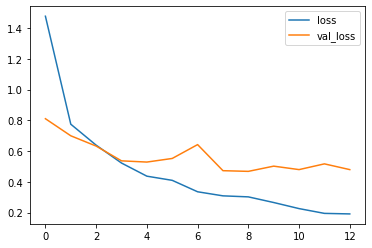

In [ ]:
df_hist = pd.DataFrame(history.history)
df_hist[["loss", "val_loss"]].plot()

## predict

In [ ]:
y_pred = model.predict(x_test)

1/1 [==============================] - 0s 119ms/step


In [ ]:
test = pd.read_csv(f"{root_dir}/test.csv")
y_test = test["labels"]

In [ ]:
y_predict = np.argmax(y_pred, axis=1)

In [ ]:
(y_test == y_predict).mean()

0.7

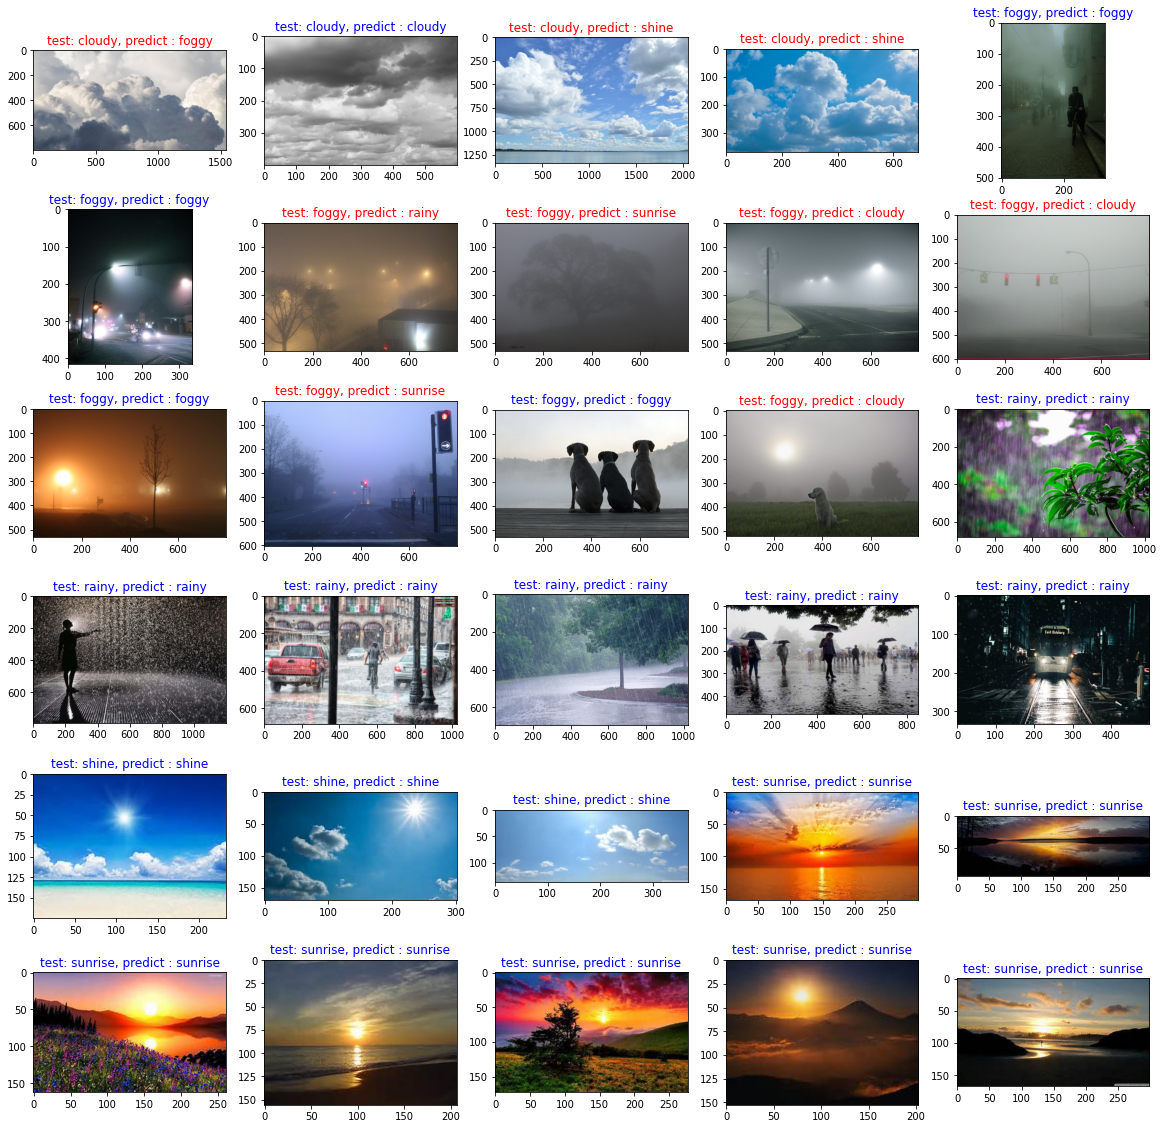

In [ ]:
class_name =  lb.classes_

fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(20, 20))
for i, tcsv in test.iterrows():
    col = i % 5
    row = i // 5
    Image_id = tcsv["Image_id"]
    img_label = tcsv["labels"]
    img = plt.imread(f"{root_dir}/alien_test/{Image_id}")
    
    color = "red"
    if img_label == y_predict[i]:
        color = "blue"
    
    axes[row, col].imshow(img)
    axes[row, col].set_title(
        f"test: {class_name[img_label]}, predict : {class_name[y_predict[i]]}", color=color)